In [1]:
import numpy as np
import datetime
import os
import random, shutil
import glob
import skillsnetwork

import warnings
warnings.simplefilter('ignore')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib.image import imread

from os import makedirs,listdir
from shutil import copyfile
from random import seed
from random import random
import keras 
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from sklearn import metrics


sns.set_context('notebook')
sns.set_style('white')

2.16.1


In [2]:
dataset_home = 'signs/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    labeldirs = ['stop/', 'not_stop/']
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        makedirs(newdir, exist_ok = True)

In [3]:
for file in listdir("stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"stop/{file}", f"signs/train/stop/{file}")
        
for file in listdir("not_stop"):
    if file != '.DS_Store':
        shutil.copyfile(f"not_stop/{file}", f"signs/train/not_stop/{file}")

test_path = "test_set_stop_not_stop/"
for file in listdir(test_path):
    if file.startswith("stop"):
        shutil.copyfile(test_path+file, f"signs/test/stop/{file}")
    elif file.startswith("not_stop"):
        shutil.copyfile(test_path+file, f"signs/test/not_stop/{file}")      
       

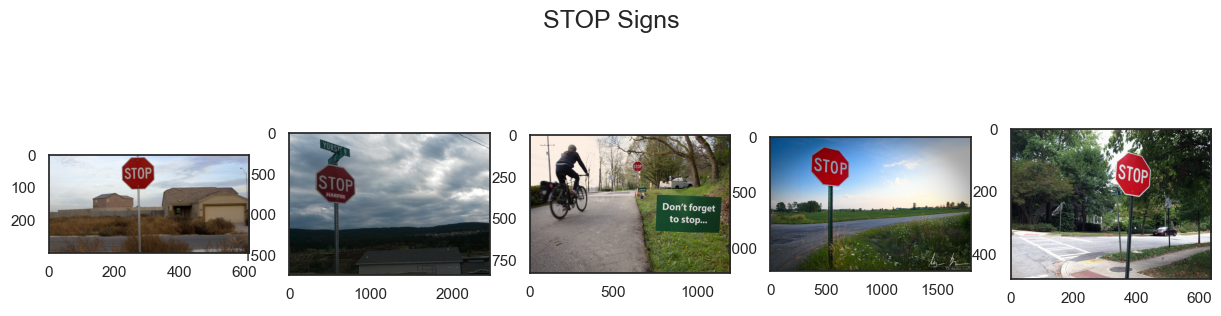

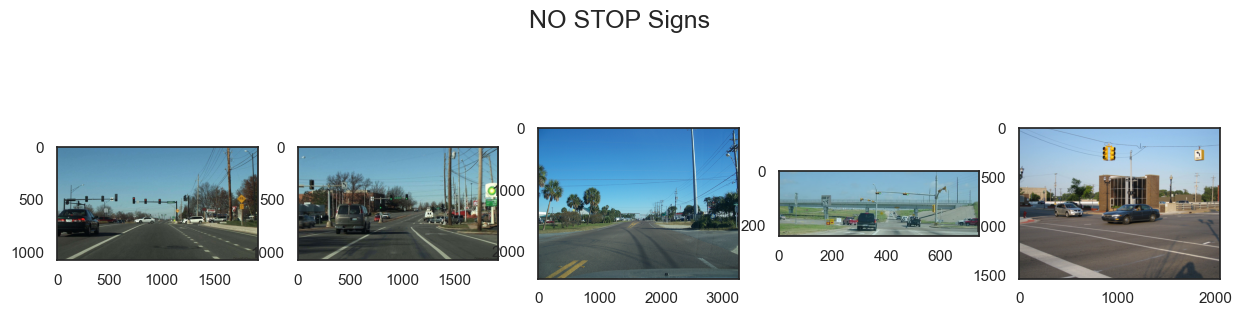

In [4]:
train_stop = glob.glob('./signs/train/stop/*')
train_not_stop = glob.glob('./signs/train/not_stop/*')

fig1, ax1 = plt.subplots(1,5,figsize=(15,4))
fig1.suptitle("STOP Signs", fontsize=18)
l1 = [ax1[i].imshow(imread(train_stop[i])) for i in range(5)]

fig2, ax2 = plt.subplots(1,5,figsize=(15,4))
fig2.suptitle("NO STOP Signs", fontsize=18)
l2 = [ax2[i].imshow(imread(train_not_stop[i])) for i in range(5)]


In [5]:
path = './signs/train/'
labels = ['stop', 'not_stop']
seed = 123
batch_size = 30
target_size = (112, 112)

In [6]:
train_datagen = ImageDataGenerator(
    validation_split = 0.2,
    rescale = 1/255,
    rotation_range = 40,
    width_shift_range = 0.2, height_shift_range = 0.2,
    shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True
)
val_datagen = ImageDataGenerator(
    validation_split = 0.2, rescale = 1.0/255.0
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'training'
)

Found 158 images belonging to 2 classes.


In [8]:
val_generator = val_datagen.flow_from_directory(
    directory = path,
    classes = labels,
    seed = seed,
    batch_size = batch_size, 
    class_mode='binary',
    shuffle = True,
    target_size=target_size,
    subset = 'validation'
)

Found 39 images belonging to 2 classes.


In [9]:
print(train_generator.class_indices)

prob2class = lambda x: 'Stop' if x < 0.5 else 'Not Stop' 

{'stop': 0, 'not_stop': 1}


In [10]:
test_files = glob.glob('signs/test/stop/*.jpg') + glob.glob('signs/test/not_stop/*.jpg')
test_imgs = [tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img, target_size=target_size)) for img in test_files]
test_imgs = np.array(test_imgs).astype('int')

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled = test_imgs/255

### Defining a helper function for building, compiling, and fitting CNNs


In [14]:
def build_compile_fit(basemodel):
    
    x = Flatten()(basemodel.output)
    
    x = Dense(1024, activation='relu')(x)
    
    x = Dropout(0.2)(x)
    
    x = Dense(1, activation='sigmoid')(x)

    model = Model(basemodel.input, x)
    model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor = 'loss', 
                    patience = 5, 
                    mode = 'min', 
                    min_delta=0.01)]

    model.fit(train_generator,
              validation_data = val_generator,
              steps_per_epoch=5, # num of batches in one epoch
              epochs=10,
              callbacks=callbacks)
    
    return model

In [15]:
from keras.applications.inception_v3 import InceptionV3

### Pre-trained Model 1: Inception-v3


In [16]:
basemodel = InceptionV3(input_shape=(112,112,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

inception_v3 = build_compile_fit(basemodel)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 109s 12s/step - accuracy: 0.4920 - loss: 4.6695 - val_accuracy: 0.5641 - val_loss: 1.0622
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.5333 - loss: 1.2775 - val_accuracy: 0.4872 - val_loss: 1.6659
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.6467 - loss: 0.7456 - val_accuracy: 0.5128 - val_loss: 1.1303
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6333 - loss: 0.5594 - val_accuracy: 0.7692 - val_loss: 0.7081
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - accuracy: 0.6179 - loss: 0.8661 - val_accuracy: 0.8205 - val_loss: 0.3311
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6667 - loss: 0.4120 - val_accuracy: 0.6667 - val_loss: 0.5980
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.7268 - loss: 0.5911 - val_accuracy: 0.8462 - val_loss: 0.4021
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7500 - loss: 0.2917 - val_accuracy: 0.8718 - val_loss: 0.3684
Epoch 9

In [17]:
# inception_v3 = build_compile_fit(basemodel)

In [18]:
# fig, ax = plt.subplots(2, 4, figsize=(12, 6))

# for i, ax in enumerate(ax.flat):
#     ax.imshow(test_imgs[i])  # Assuming test_imgs contains your test images
#     pred_class = prob2class(inception_v3.predict(test_imgs_scaled[i].reshape(1, 112, 112, 3)))
#     ax.set_title(pred_class, fontsize=15)
#     ax.axis("off")

# plt.show()


### Pre-trained Model 2: MobileNet


In [19]:
from keras.applications.mobilenet import MobileNet

In [20]:
basemodel = MobileNet(input_shape=(112,112,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

mobile_net = build_compile_fit(basemodel)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.4999 - loss: 5.2282 - val_accuracy: 0.7949 - val_loss: 0.8816
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.5667 - loss: 1.5300 - val_accuracy: 0.5385 - val_loss: 2.1887
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8122 - loss: 0.7355 - val_accuracy: 0.9231 - val_loss: 0.1720
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8000 - loss: 0.2327 - val_accuracy: 0.6923 - val_loss: 0.9089
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.8355 - loss: 0.3055 - val_accuracy: 0.6410 - val_loss: 0.9260
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9333 - loss: 0.1369 - val_accuracy: 0.7949 - val_loss: 0.4351
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.8637 - loss: 0.3278 - val_accuracy: 0.8718 - val_loss: 0.3563
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7000 - loss: 0.8527 - val_accuracy: 0.4872 - val_loss: 2.0068
Epoch 9/10
5

In [21]:
# fig, ax = plt.subplots(2, 4, figsize=(12, 6))

# for i, ax in enumerate(ax.flat):
#     ax.imshow(test_imgs[i])
#     pred_class = prob2class(mobile_net.predict(test_imgs_scaled[i].reshape(1, 112, 112,3)))
    
#     # print the predicted class label as the title of the image
#     ax.set_title(pred_class, fontsize=15)
#     ax.axis("off")
    

### Pre-trained Model 3: ResNet-50


In [23]:
from keras.applications import ResNet50

basemodel = ResNet50(input_shape=(112,112,3),
                          include_top = False,
                          weights = 'imagenet')

for layer in basemodel.layers:
    layer.trainable = False

resnet_50 = build_compile_fit(basemodel)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 118s 15s/step - accuracy: 0.4646 - loss: 3.2066 - val_accuracy: 0.5128 - val_loss: 1.1359
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5000 - loss: 0.5992 - val_accuracy: 0.4872 - val_loss: 2.7185
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 59s 9s/step - accuracy: 0.4669 - loss: 1.9494 - val_accuracy: 0.5128 - val_loss: 2.3003
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 61s 13s/step - accuracy: 0.5000 - loss: 1.4707 - val_accuracy: 0.4872 - val_loss: 1.0948
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 15s/step - accuracy: 0.4374 - loss: 1.4922 - val_accuracy: 0.5128 - val_loss: 1.0571
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.5000 - loss: 0.5984 - val_accuracy: 0.4872 - val_loss: 1.3631
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 93s 12s/step - accuracy: 0.6004 - loss: 0.9491 - val_accuracy: 0.5128 - val_loss: 0.6730


In [24]:
# fig, ax = plt.subplots(2, 4, figsize=(12, 6))

# for i, ax in enumerate(ax.flat):
#     ax.imshow(test_imgs[i])
#     pred_class = prob2class(resnet_50.predict(test_imgs_scaled[i].reshape(1, 112, 112,3)))
    
#     # print the predicted class label as the title of the image
#     ax.set_title(pred_class, fontsize=15)
#     ax.axis("off")